In [ ]:
import os
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tqdm import tqdm
# Path to your LG font images directory
image_dir = '/Selected_LG'

# Load the dataset from Hugging Face
dataset = load_dataset('ta4tsering/Lhasa_kanjur_transcription_datasets', split='test')

# Load the pre-trained RoBERTa model and tokenizer
model_name = 'openpecha/tibetan_RoBERTa_S_e6'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

# Prepare the dataset: Map filenames to transcriptions
filename_to_transcription = {row['filename']: row['label'] for row in dataset}

# Function to convert text to vector using the RoBERTa model
def text_to_vector(text):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=512)
    outputs = model(inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1)  # Use mean pooling

# Collect vectors and corresponding images
data = []
for filename in tqdm(os.listdir(image_dir)):
    transcription = filename_to_transcription.get(filename)
    if transcription:
        vector = text_to_vector(transcription)
        image_path = os.path.join(image_dir, filename)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.resize(image, [64, 2048])
        image = image / 255.0  # Normalize to [0, 1]
        data.append((vector, image))

# Convert list to TensorFlow dataset
vectors, images = zip(*data)
vectors = tf.convert_to_tensor(vectors)
images = tf.convert_to_tensor(images)
dataset = tf.data.Dataset.from_tensor_slices((images, vectors))


2024-07-15 09:55:14.503759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 09:55:14.522772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 09:55:14.522807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 09:55:14.537159: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 09:55:18.202065: I tensorflow/core/common

In [ ]:
from tensorflow.keras import layers, Model

# Custom Keras layer to expand and tile dimensions
class ExpandAndTileLayer(layers.Layer):
    def __init__(self, tile_shape):
        super(ExpandAndTileLayer, self).__init__()
        self.tile_shape = tile_shape

    def call(self, inputs):
        expanded = tf.expand_dims(tf.expand_dims(inputs, 1), 1)
        return tf.tile(expanded, [1, self.tile_shape[0], self.tile_shape[1], 1])

# Define the conditional UNet architecture
def create_conditional_unet(input_shape, condition_dim):
    inputs = layers.Input(shape=input_shape)
    condition = layers.Input(shape=(condition_dim,))
    
    # Combine inputs and conditions
    condition_tiled = ExpandAndTileLayer(input_shape[:2])(condition)
    x = layers.Concatenate()([inputs, condition_tiled])

    # Add convolutional layers
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Add upsampling layers
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model([inputs, condition], outputs)

input_shape = (64, 2048, 1)  # Adjust based on your image dimensions
condition_dim = 768  # Dimensionality of the transcription vectors

unet_model = create_conditional_unet(input_shape, condition_dim)
unet_model.summary()


In [ ]:
# Define the DDPM training process
def train_ddpm(model, dataset, epochs, batch_size):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    mse_loss = tf.keras.losses.MeanSquaredError()

    for epoch in range(epochs):
        for step, (images, conditions) in enumerate(dataset.batch(batch_size)):
            with tf.GradientTape() as tape:
                # Forward diffusion step
                noisy_images = images + tf.random.normal(shape=images.shape, mean=0.0, stddev=0.1)
                conditions = tf.squeeze(conditions, axis=1)  # Squeeze the extra dimension
                predicted_images = model([noisy_images, conditions])

                # Compute loss
                loss = mse_loss(images, predicted_images)

            # Backpropagation
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            if step % 100 == 0:
                print(f'Epoch {epoch + 1}, Step {step}, Loss: {loss.numpy()}')

train_ddpm(unet_model, dataset, epochs=10, batch_size=16)


W0000 00:00:1721037113.944049  157516 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721037113.948043  157516 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721037113.952758  157516 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721037113.957283  157516 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721037113.961724  157516 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721037113.965627  157516 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721037113.970783  157516 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721037113.975511  157516 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721037113.979459  157516 gp

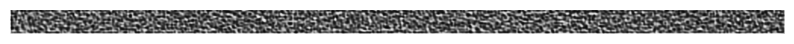

In [31]:
import matplotlib.pyplot as plt

def generate_image_from_transcription(model, transcription_vector, noise_shape):
    # Create random noise
    noise = tf.random.normal(shape=noise_shape)

    # Predict the image from noise given the transcription vector
    transcription_vector = tf.expand_dims(transcription_vector, axis=0)  # Add batch dimension
    transcription_vector = tf.squeeze(transcription_vector, axis=1)  # Squeeze the extra dimension
    generated_image = model([noise, transcription_vector], training=False)

    return generated_image[0, :, :, 0].numpy()

# Take a sample transcription vector from the training data
sample_transcription_vector = vectors[0]  # Use the first vector in the dataset
noise_shape = (1, 64, 2048, 1)  # Shape of the noise input

# Generate an image
generated_image = generate_image_from_transcription(unet_model, sample_transcription_vector, noise_shape)

# Display the generated image
plt.figure(figsize=(10, 2))
plt.imshow(generated_image, cmap='gray')
plt.axis('off')
plt.show()
